# Perbandingan Efektivitas Algoritma XGBoost dan MLP pada Klasifikasi Penyakit Diabetes

In [30]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings('ignore')

### Data Loading

In [31]:
# Load dataset
df = pd.read_csv("../data/Dataset of Diabetes  .csv")
df.head()

,ID,No_Pation,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,CLASS
0,502,17975,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
1,735,34221,M,26,4.5,62,4.9,3.7,1.4,1.1,2.1,0.6,23.0,N
2,420,47975,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
3,680,87656,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
4,504,34223,M,33,7.1,46,4.9,4.9,1.0,0.8,2.0,0.4,21.0,N


class nya itu ada Diabetic, Non-Diabetic, and Predicted-
Diabetic

### Ringkasan Statistik Awal

In [32]:
# Informasi umum dataset
df.info()

# Statistik deskriptif
df.describe(include='all')
# Tujuan: melihat tipe data, missing values, distribusi nilai minimum, maksimum, rata-rata, dll.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         1000 non-null   int64  
 1   No_Pation  1000 non-null   int64  
 2   Gender     1000 non-null   object 
 3   AGE        1000 non-null   int64  
 4   Urea       1000 non-null   float64
 5   Cr         1000 non-null   int64  
 6   HbA1c      1000 non-null   float64
 7   Chol       1000 non-null   float64
 8   TG         1000 non-null   float64
 9   HDL        1000 non-null   float64
 10  LDL        1000 non-null   float64
 11  VLDL       1000 non-null   float64
 12  BMI        1000 non-null   float64
 13  CLASS      1000 non-null   object 
dtypes: float64(8), int64(4), object(2)
memory usage: 109.5+ KB


,ID,No_Pation,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,CLASS
count,1000.000000,1.000000e+03,1000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000
unique,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
top,NaN,NaN,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y
freq,NaN,NaN,565,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,840
mean,340.500000,2.705514e+05,NaN,53.528000,5.124743,68.943000,8.281160,4.862820,2.349610,1.204750,2.609790,1.854700,29.578020,NaN
std,240.397673,3.380758e+06,NaN,8.799241,2.935165,59.984747,2.534003,1.301738,1.401176,0.660414,1.115102,3.663599,4.962388,NaN
min,1.000000,1.230000e+02,NaN,20.000000,0.500000,6.000000,0.900000,0.000000,0.300000,0.200000,0.300000,0.100000,19.000000,NaN
25%,125.750000,2.406375e+04,NaN,51.000000,3.700000,48.000000,6.500000,4.000000,1.500000,0.900000,1.800000,0.700000,26.000000,NaN
50%,300.500000,3.439550e+04,NaN,55.000000,4.600000,60.000000,8.000000,4.800000,2.000000,1.100000,2.500000,0.900000,30.000000,NaN
75%,550.250000,4.538425e+04,NaN,59.000000,5.700000,73.000000,10.200000,5.600000,2.900000,1.300000,3.300000,1.500000,33.000000,NaN


In [33]:
# Melihat nama kolom untuk identifikasi kolom label
print(df.columns)


Index(['ID', 'No_Pation', 'Gender', 'AGE', 'Urea', 'Cr', 'HbA1c', 'Chol', 'TG',
       'HDL', 'LDL', 'VLDL', 'BMI', 'CLASS'],
      dtype='object')


#### PreProcessing Data
Pengelohan data sebelum digunakan

In [34]:
# 1.2. Drop duplikat
df = df.drop_duplicates()

# 1.3. Hapus outlier sederhana dengan IQR pada tiap kolom numerik
num_cols = df.select_dtypes(include=["int64","float64"]).columns
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    df = df[(df[col] >= lower) & (df[col] <= upper)]

# 1.4. Pisahkan fitur & target
X = df.drop("CLASS", axis=1)
y = df["CLASS"]


Hapus Duplikat - Berikan batas akhir dan awal untuk data yang tidak normal - Memisahkan sebuah fitur dan target (class)

In [35]:
# Cek dan hapus duplikat
print("Jumlah duplikat sebelum dibersihkan:", df.duplicated().sum())
df = df.drop_duplicates()
print("Jumlah data setelah drop duplikat:", df.shape)


Jumlah duplikat sebelum dibersihkan: 0
Jumlah data setelah drop duplikat: (629, 14)


#### Pemberian Label agar lebih rapi

In [36]:
# Normalisasi label CLASS
df['CLASS'] = df['CLASS'].astype(str).str.strip().str.upper()

# Tampilkan distribusi kelas setelah normalisasi
print("Distribusi kelas setelah normalisasi label:")
print(df['CLASS'].value_counts())


Distribusi kelas setelah normalisasi label:
CLASS
Y    557
N     47
P     25
Name: count, dtype: int64


#### Pisahkan Fitur dan Target
setelahnya lakukan split data yang sebagian data bernilai 20%  untuk menguji dan 80 % untuk belajar

In [37]:
# Pisahkan fitur dan label
X = df.drop(columns=['CLASS'])
y = df['CLASS']

# Split data menjadi train dan test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Distribusi label di data latih:", y_train.value_counts())


Distribusi label di data latih: CLASS
Y    445
N     38
P     20
Name: count, dtype: int64


In [38]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

# Encode kolom 'Gender' menjadi angka
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])  # Misal 'F' -> 0, 'M' -> 1

# Pisahkan fitur dan target
X = df.drop("CLASS", axis=1)
y = df["CLASS"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42)

# Resampling SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


Kalau jumlah kelasnya tidak seimbang (misal terlalu banyak "YA" dibanding "TIDAK"),
SMOTE bantu menambah data palsu yang mirip aslinya biar adil jumlahnya.

Karena kalau satu kelas jauh lebih banyak dari yang lain, model bisa belajar hal yang salah.

### Cek Keseimbangan Kelas Target

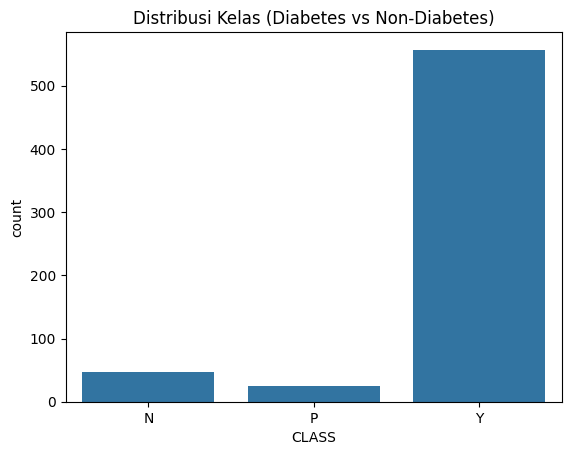

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='CLASS', data=df)
plt.title("Distribusi Kelas (Diabetes vs Non-Diabetes)")
plt.show()

#Tujuan: Apakah data target CLASS (N vs P) seimbang? Jika tidak, bisa pertimbangkan teknik resampling (SMOTE/ROS).


### Distribusi Fitur Numerik

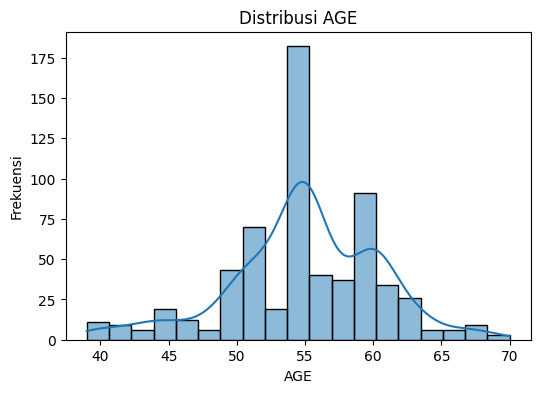

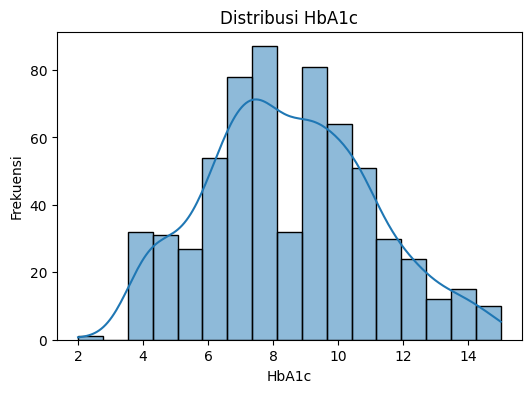

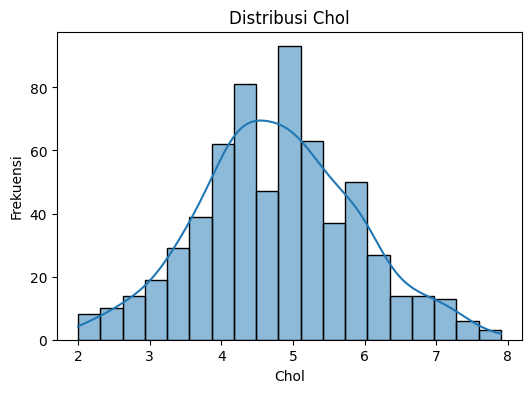

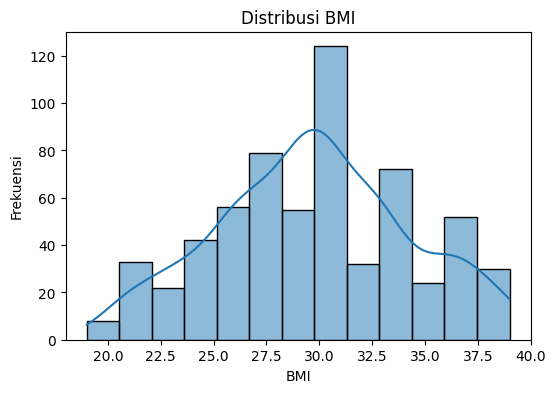

In [40]:
# Contoh: distribusi fitur penting
features = ['AGE', 'HbA1c', 'Chol', 'BMI']

for col in features:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribusi {col}')
    plt.xlabel(col)
    plt.ylabel('Frekuensi')
    plt.show()
# Tujuan: Memahami distribusi fitur penting dalam dataset. Apakah ada outlier atau distribusi yang tidak normal?
# Mengetahui apakah fitur berdistribusi normal, skewed, atau memiliki outlier.




### Korelasi Antar Variabel

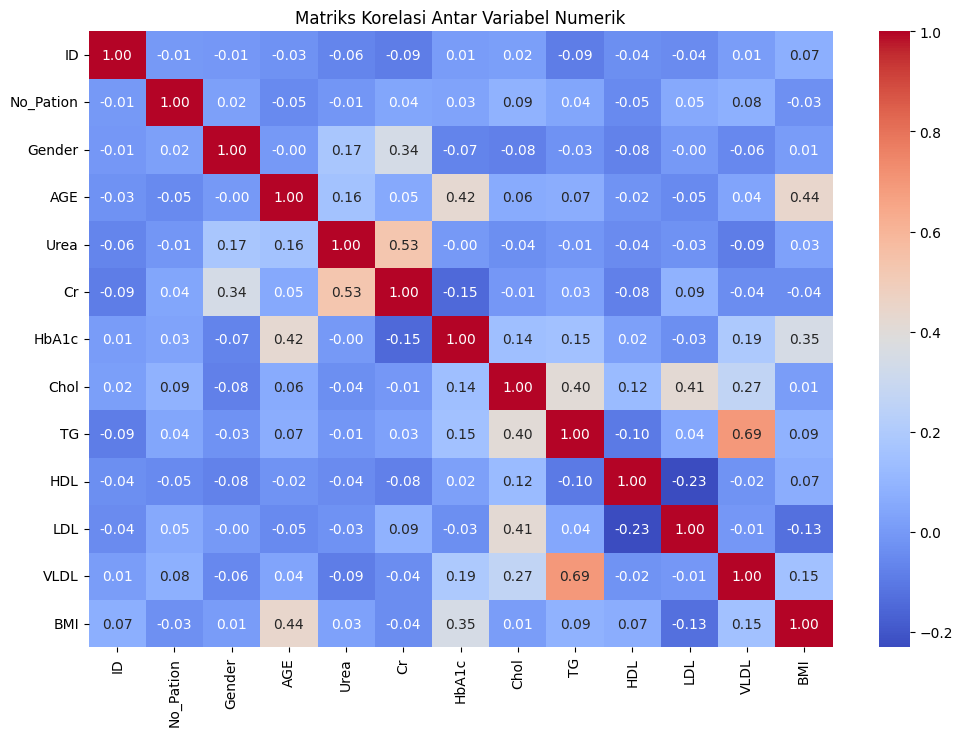

In [41]:
# Korelasi antar fitur numerik
plt.figure(figsize=(12, 8))
corr = df.select_dtypes(include='number').corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriks Korelasi Antar Variabel Numerik')
plt.show()
# 📌 Tujuan: Mengetahui fitur-fitur yang sangat berkorelasi (positif atau negatif). Bisa jadi petunjuk untuk feature selection atau multikolinearitas.

### Korelasi Fitur terhadap Target

In [42]:
# Salin dataframe dan encode kolom CLASS
df_corr = df.copy()
df_corr['CLASS'] = df_corr['CLASS'].map({'N': 0, 'P': 1})

# Drop kolom non-numerik lainnya (misalnya: Gender)
df_corr = df_corr.drop(columns=['Gender'])  # bisa ditambah kolom string lainnya jika ada

# Hitung korelasi terhadap CLASS
target_corr = df_corr.corr(numeric_only=True)['CLASS'].sort_values(ascending=False)
print("Korelasi Fitur terhadap Target (CLASS):")
print(target_corr)

# Tujuan: Mengetahui fitur mana yang paling berkaitan dengan diabetes.


Korelasi Fitur terhadap Target (CLASS):
CLASS        1.000000
HbA1c        0.857388
BMI          0.482559
TG           0.408640
VLDL         0.340689
Chol         0.130196
Cr           0.084951
AGE          0.074315
HDL         -0.067566
Urea        -0.067841
LDL         -0.112471
No_Pation   -0.214617
ID          -0.232763
Name: CLASS, dtype: float64


### Visualisasi Pairplot 

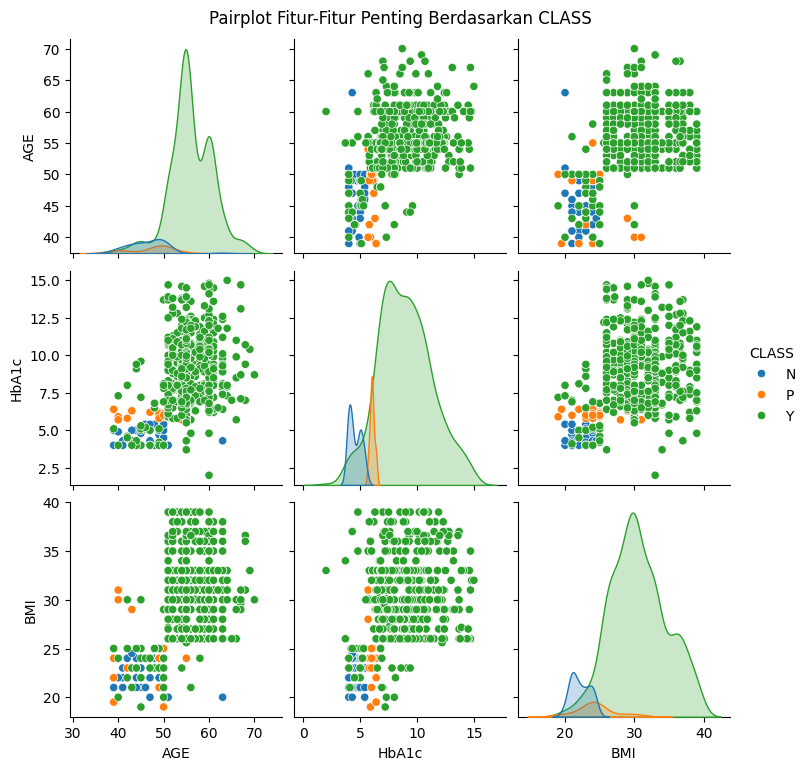

In [43]:
sns.pairplot(df, hue='CLASS', vars=['AGE', 'HbA1c', 'BMI'])
plt.suptitle("Pairplot Fitur-Fitur Penting Berdasarkan CLASS", y=1.02)
plt.show()
# Tujuan: Visualisasi hubungan antar fitur penting dengan target CLASS. Apakah ada pola yang jelas antara fitur dan kelas?

Makna Pairplot
Pairplot menunjukkan hubungan antar fitur numerik (seperti AGE, HbA1c, BMI, dsb.) dan bagaimana mereka berbeda antar kelas target (CLASS: N, P, Y):

Diagonal: menunjukkan distribusi tiap fitur berdasarkan kelas (dengan kurva kernel density estimation).

Bawah-diagonal/Atas-diagonal: scatter plot yang menggambarkan hubungan antar dua fitur, dengan warna yang menunjukkan masing-masing kelas.

Misalnya:

Distribusi HbA1c terlihat sangat berbeda antara kelas N (biru), P (oranye), dan Y (hijau).

Titik-titik CLASS Y (hijau) sangat dominan pada nilai HbA1c yang tinggi, ini terlihat dari padatnya titik hijau pada area atas HbA1c.

- Pairplot membantu visualisasi hubungan antar fitur dan distribusinya terhadap kelas target.

- Korelasi numerik menunjukkan kekuatan hubungan fitur terhadap CLASS.

- Fitur HbA1c, BMI, dan TG adalah yang paling penting dan membedakan kelas dengan jelas.

- Korelasi mendukung apa yang terlihat di pairplot: semakin tinggi korelasinya, semakin jelas perbedaan distribusi kelasnya di visual.

## PENGEMBANGAN MODEL MACHINE LEARNING

In [44]:
print(y.value_counts())


CLASS
Y    557
N     47
P     25
Name: count, dtype: int64


### Preprocessing (Encode & Scaling)

In [45]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Salin data
df_model = df.copy()

# Hapus label dengan jumlah terlalu sedikit
label_counts = df_model['CLASS'].value_counts()
valid_labels = label_counts[label_counts >= 2].index
df_model = df_model[df_model['CLASS'].isin(valid_labels)].copy()

# Encode CLASS (multiclass)
le_class = LabelEncoder()
df_model['CLASS'] = le_class.fit_transform(df_model['CLASS'])

# Encode Gender
df_model['Gender'] = LabelEncoder().fit_transform(df_model['Gender'])

# Drop kolom lain jika masih ada
df_model.drop(columns=['ID', 'No_Pation'], inplace=True, errors='ignore')

# Pisahkan fitur dan target
X = df_model.drop(columns=['CLASS'])
y = df_model['CLASS']

# Normalisasi
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42)


In [46]:
from imblearn.over_sampling import SMOTE
from collections import Counter

print("Distribusi sebelum SMOTE:", Counter(y_train))

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Distribusi setelah SMOTE:", Counter(y_train_smote))


Distribusi sebelum SMOTE: Counter({2: 445, 0: 38, 1: 20})
Distribusi setelah SMOTE: Counter({2: 445, 0: 445, 1: 445})


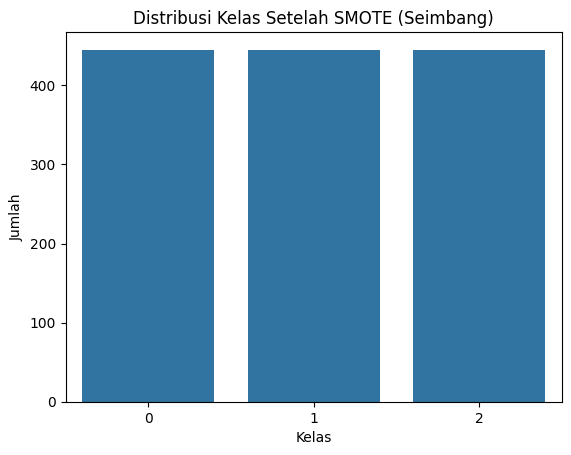

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Membuat DataFrame baru dari hasil SMOTE
df_smote = pd.DataFrame({'CLASS': y_train_smote})

# Visualisasi distribusi kelas setelah SMOTE
sns.countplot(x='CLASS', data=df_smote)
plt.title("Distribusi Kelas Setelah SMOTE (Seimbang)")
plt.xlabel("Kelas")
plt.ylabel("Jumlah")
plt.show()


### Preprocessing Data untuk Klasifikasi Multiclass

Dokumen ini menjelaskan tahapan preprocessing yang dilakukan dalam proyek klasifikasi penyakit diabetes menggunakan algoritma seperti XGBoost dan MLPClassifier. Dataset awal mengandung label `CLASS` dan beberapa fitur medis seperti `AGE`, `HbA1c`, dan `BMI`.
### 1. Salin Data
```python
df_model = df.copy()
```
Menyalin dataframe asli untuk menjaga data mentah tetap utuh.


### 2. Buang Kelas yang Terlalu Sedikit
```python
label_counts = df_model['CLASS'].value_counts()
valid_labels = label_counts[label_counts >= 2].index
df_model = df_model[df_model['CLASS'].isin(valid_labels)].copy()
```
Kelas dengan jumlah <2 dibuang karena `train_test_split(stratify=...)` membutuhkan minimal 2 sampel per kelas.


### 3. Encode CLASS (Multiclass)
```python
from sklearn.preprocessing import LabelEncoder
le_class = LabelEncoder()
df_model['CLASS'] = le_class.fit_transform(df_model['CLASS'])
```
Label `CLASS` diubah dari string menjadi angka seperti `0`, `1`, `2`


### 4. Encode Gender
```python
df_model['Gender'] = LabelEncoder().fit_transform(df_model['Gender'])
```
Kolom `Gender` dikonversi ke angka: `'F'` → 0, `'M'` → 1.


### 5. Hapus Kolom Tidak Relevan
```python
df_model.drop(columns=['ID', 'No_Pation'], inplace=True, errors='ignore')
```
Kolom identitas dihapus karena tidak berkontribusi dalam prediksi.


### 6. Pisahkan Fitur dan Target
```python
X = df_model.drop(columns=['CLASS'])
y = df_model['CLASS']
```
- `X`: Fitur yang digunakan untuk pelatihan
- `y`: Label target yang ingin diprediksi


### 7. Normalisasi Fitur
```python
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
```
Fitur dinormalisasi agar berada dalam skala yang sama, menghindari dominasi fitur berskala besar.


### 8. Split Data: Train & Test
```python
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42)
```
- Data dibagi 80% untuk pelatihan, 20% untuk pengujian
- `stratify=y` menjaga proporsi label tetap seimbang
- `random_state=42` memastikan hasil dapat direproduksi



In [48]:
print("y_train:", sorted(y_train.unique()))
print("y_test :", sorted(y_test.unique()))


y_train: [0, 1, 2]
y_test : [0, 1, 2]


#### Hyperparameter Tuning Manual untuk XGboost

In [49]:
best_score = 0
best_params = {}

for n in [50, 100]:
    for depth in [3, 5]:
        for lr in [0.01, 0.1]:
            model = XGBClassifier(n_estimators=n, max_depth=depth, learning_rate=lr,
                                  use_label_encoder=False, eval_metric='logloss', random_state=42)
            model.fit(X_train_smote, y_train_smote)
            preds = model.predict(X_test)
            acc = accuracy_score(y_test, preds)
            print("Accuracy on real test set:", acc)
            print(f"Params: n_estimators={n}, max_depth={depth}, learning_rate={lr} → acc={acc}")
            if acc > best_score:
                best_score = acc
                best_params = {'n_estimators': n, 'max_depth': depth, 'learning_rate': lr}

print("Best Params:", best_params)


Accuracy on real test set: 0.9444444444444444
Params: n_estimators=50, max_depth=3, learning_rate=0.01 → acc=0.9444444444444444
Accuracy on real test set: 0.9920634920634921
Params: n_estimators=50, max_depth=3, learning_rate=0.1 → acc=0.9920634920634921
Accuracy on real test set: 0.9603174603174603
Params: n_estimators=50, max_depth=5, learning_rate=0.01 → acc=0.9603174603174603
Accuracy on real test set: 0.9920634920634921
Params: n_estimators=50, max_depth=5, learning_rate=0.1 → acc=0.9920634920634921
Accuracy on real test set: 0.9444444444444444
Params: n_estimators=100, max_depth=3, learning_rate=0.01 → acc=0.9444444444444444
Accuracy on real test set: 0.9920634920634921
Params: n_estimators=100, max_depth=3, learning_rate=0.1 → acc=0.9920634920634921
Accuracy on real test set: 0.9603174603174603
Params: n_estimators=100, max_depth=5, learning_rate=0.01 → acc=0.9603174603174603
Accuracy on real test set: 0.9920634920634921
Params: n_estimators=100, max_depth=5, learning_rate=0.1 →

- n_estimators=n : berapa banyak pohon keuputsan yang digunakan
- max depth : seberapa dalam pohonnya
- learning rate : seberapa cepat model belajar

gunanya : 
1. mencari semua kombinasi
2. melatih dengan data latihan
3. uji 
4. mencatat sebrapa bagus prediksnya
5. kalau ada yang lebih bagus dari sebelumnya maka dia yang akan dipakai

dilakukan secara manual . klo tidak manual dia make GridSearchCV

###  Model 1: XGBoost Classifier

xgboost = extreme gradient boosting dipakai untuk prediksi klasifikasi dan regresi , next generatioan dari, algoritma mL yang paling kuat dan cepat

💡 Kenapa XGBoost Populer?
Karena:

✅ Akurat – sering menang kompetisi data science.

⚡ Cepat – lebih cepat dari banyak algoritma lain.

🎯 Pintar – menggunakan banyak "pohon keputusan" yang saling bantu untuk memperbaiki kesalahan.

🔧 Fleksibel – bisa dipakai untuk banyak tipe data dan masalah.

🛠️ Mendukung tuning parameter – cocok untuk dicoba-coba agar akurasi makin tinggi.



In [68]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=50,
    max_depth=5,
    learning_rate=0.1,  # sedikit lebih agresif dari 0.01
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
# // Penjelasan parameter XGBClassifier:
 
#n_estimators=50: Jumlah pohon keputusan yang akan dibuat. Semakin banyak, semakin baik, tapi juga lebih lambat.
 
#max_depth=5: Kedalaman maksimum setiap pohon keputusan. Ini mengontrol kompleksitas model.
 
#learning_rate=0.1: Kecepatan belajar model. Nilai ini mengontrol seberapa besar perubahan yang dilakukan pada setiap iterasi.
 
#use_label_encoder=False: Menghindari peringatan terkait pengkodean label bawaan XGBoost.
 
#eval_metric='logloss': Metode evaluasi performa model. Logloss adalah ukuran seberapa baik model memprediksi probabilitas kelas.
 
# random_state=42: Untuk memastikan hasil yang konsisten setiap kali kode dijalankan.



# Training model pada data hasil SMOTE
xgb_model.fit(X_train_smote, y_train_smote)

# Prediksi dan probabilitas
xgb_preds = xgb_model.predict(X_test)
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]


Membangun model klasifikasi berbasis ensemble gradient boosting, yang sangat kuat dalam mendeteksi pola kompleks dan cocok untuk data tabular, bahkan saat ada missing value atau outlier.

dengan pemahaman kode yang saya pahami : 
- XGBClassifier(...) : ntuk membuat model XGBoost untuk klasfikasi
- Use_label itu agar selalu up to date
- eval_metric = penggunaan log loss untuk evaluasi multiclass
- randomstate = membuat hasil konsisten
- fit x dan y = pelatihan nya
- predik = predik
- predic proba = penghasilkan probabilitas yang diklasifikan menjadi kelas 1

* Log Loss mengukur seberapa jauh prediksi probabilitas dari kenyataan.
Semakin kecil nilai log loss, semakin baik prediksi model.

#### Hasil Evaluasi Model 

In [51]:
import pandas as pd

# Simpan hasil tuning XGBoost
xgb_results = []

for n in [50, 100]:
    for depth in [3, 5]:
        for lr in [0.01, 0.1]:
            model = XGBClassifier(n_estimators=n, max_depth=depth, learning_rate=lr,
                                  use_label_encoder=False, eval_metric='logloss', random_state=42)
            model.fit(X_train_smote, y_train_smote)
            preds = model.predict(X_test)
            acc = accuracy_score(y_test, preds)
            xgb_results.append({
                'n_estimators': n,
                'max_depth': depth,
                'learning_rate': lr,
                'accuracy': acc
            })

# Buat DataFrame
xgb_df = pd.DataFrame(xgb_results)
print("Hasil Tuning XGBoost:")
print(xgb_df.sort_values(by='accuracy', ascending=False))


Hasil Tuning XGBoost:
   n_estimators  max_depth  learning_rate  accuracy
1            50          3           0.10  0.992063
3            50          5           0.10  0.992063
5           100          3           0.10  0.992063
7           100          5           0.10  0.992063
2            50          5           0.01  0.960317
6           100          5           0.01  0.960317
0            50          3           0.01  0.944444
4           100          3           0.01  0.944444


In [52]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Accuracy:", accuracy_score(y_test, xgb_preds))
print("Confusion Matrix:\n", confusion_matrix(y_test, xgb_preds))
print("Classification Report:\n", classification_report(y_test, xgb_preds))


Accuracy: 0.9920634920634921
Confusion Matrix:
 [[  9   0   0]
 [  0   5   0]
 [  1   0 111]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95         9
           1       1.00      1.00      1.00         5
           2       1.00      0.99      1.00       112

    accuracy                           0.99       126
   macro avg       0.97      1.00      0.98       126
weighted avg       0.99      0.99      0.99       126



- precision : berapa banyak yang benar
- recall : berapa yang berhasil ditemukan oleh model
- f1-score : rata rata gabungan antara precision dan recal
- support : jumlah data asli 
- accuracy : presentasi tebakan dari model 

### Model 2: MLP Classifier

MLP (Multilayer Perceptron) adalah salah satu jenis dari jaringan saraf tiruan (artificial neural network) yang dipakai dalam machine learning untuk menebak, mengklasifikasikan, atau memprediksi sesuatu berdasarkan data.

- input 
- hidden
- output


In [53]:
from sklearn.neural_network import MLPClassifier

best_score = 0
best_params = {}

for hls in [(50,), (100,)]:
    for alpha in [0.0001, 0.001]:
        for lr in [0.001, 0.01]:
            model = MLPClassifier(hidden_layer_sizes=hls, alpha=alpha, learning_rate_init=lr, max_iter=500, random_state=42)
            model.fit(X_train_smote, y_train_smote)
            acc = model.score(X_test, y_test)
            print(f"Params: hidden_layer_sizes={hls}, alpha={alpha}, learning_rate_init={lr} → acc={acc}")
            if acc > best_score:
                best_score = acc
                best_params = {'hidden_layer_sizes': hls, 'alpha': alpha, 'learning_rate_init': lr}

print("Best MLP Params:", best_params)


Params: hidden_layer_sizes=(50,), alpha=0.0001, learning_rate_init=0.001 → acc=0.9365079365079365
Params: hidden_layer_sizes=(50,), alpha=0.0001, learning_rate_init=0.01 → acc=0.9365079365079365
Params: hidden_layer_sizes=(50,), alpha=0.001, learning_rate_init=0.001 → acc=0.9365079365079365
Params: hidden_layer_sizes=(50,), alpha=0.001, learning_rate_init=0.01 → acc=0.9365079365079365
Params: hidden_layer_sizes=(100,), alpha=0.0001, learning_rate_init=0.001 → acc=0.9365079365079365
Params: hidden_layer_sizes=(100,), alpha=0.0001, learning_rate_init=0.01 → acc=0.9285714285714286
Params: hidden_layer_sizes=(100,), alpha=0.001, learning_rate_init=0.001 → acc=0.9365079365079365
Params: hidden_layer_sizes=(100,), alpha=0.001, learning_rate_init=0.01 → acc=0.9285714285714286
Best MLP Params: {'hidden_layer_sizes': (50,), 'alpha': 0.0001, 'learning_rate_init': 0.001}


In [54]:
mlp_model = MLPClassifier(
    hidden_layer_sizes=best_params['hidden_layer_sizes'],
    alpha=best_params['alpha'],
    learning_rate_init=best_params['learning_rate_init'],
    max_iter=500,
    random_state=42
)
mlp_model.fit(X_train_smote, y_train_smote)

mlp_preds = mlp_model.predict(X_test)
mlp_probs = mlp_model.predict_proba(X_test)[:, 1]


Membangun model klasifikasi berbasis neural network yang mampu mempelajari hubungan non-linear antar fitur, cocok untuk data numerik yang telah dinormalisasi (StandardScaler sangat penting di sini).

Dengan pemahaman kode model  :
- mlpclasifika = klasfikasi
- hidden layer = pembuatan hidden layer (100 neuron)
- max_iter =  melakukan iterasi training hingga 300 x
- random state = membuat hasil konsisten
- fit x & y = pelatihan
- predic dan predicproba = sama aja penjelasannya

In [55]:
mlp_results = []

for hls in [(50,), (100,)]:
    for alpha in [0.0001, 0.001]:
        for lr in [0.001, 0.01]:
            model = MLPClassifier(hidden_layer_sizes=hls, alpha=alpha, learning_rate_init=lr,
                                  max_iter=500, random_state=42)
            model.fit(X_train_smote, y_train_smote)
            acc = model.score(X_test, y_test)
            mlp_results.append({
                'hidden_layer_sizes': hls,
                'alpha': alpha,
                'learning_rate_init': lr,
                'accuracy': acc
            })

# Buat DataFrame
mlp_df = pd.DataFrame(mlp_results)
print("Hasil Tuning MLPClassifier:")
print(mlp_df.sort_values(by='accuracy', ascending=False))


Hasil Tuning MLPClassifier:
  hidden_layer_sizes   alpha  learning_rate_init  accuracy
0              (50,)  0.0001               0.001  0.936508
1              (50,)  0.0001               0.010  0.936508
2              (50,)  0.0010               0.001  0.936508
3              (50,)  0.0010               0.010  0.936508
4             (100,)  0.0001               0.001  0.936508
6             (100,)  0.0010               0.001  0.936508
5             (100,)  0.0001               0.010  0.928571
7             (100,)  0.0010               0.010  0.928571


In [56]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("MLP Accuracy:", accuracy_score(y_test, mlp_preds))
print("MLP Confusion Matrix:\n", confusion_matrix(y_test, mlp_preds))
print("MLP Classification Report:\n", classification_report(y_test, mlp_preds))


MLP Accuracy: 0.9365079365079365
MLP Confusion Matrix:
 [[  7   1   1]
 [  2   2   1]
 [  1   2 109]]
MLP Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.78      0.74         9
           1       0.40      0.40      0.40         5
           2       0.98      0.97      0.98       112

    accuracy                           0.94       126
   macro avg       0.69      0.72      0.70       126
weighted avg       0.94      0.94      0.94       126



 ### Evaluasi Model (Akurasi, Laporan Klasifikasi)

In [57]:
from sklearn.metrics import accuracy_score, classification_report

# Evaluasi XGBoost
print("XGBoost Performance:")
print("Akurasi:", accuracy_score(y_test, xgb_preds))
print(classification_report(y_test, xgb_preds))

# Evaluasi MLP
print("\nMLPClassifier Performance:")
print("Akurasi:", accuracy_score(y_test, mlp_preds))
print(classification_report(y_test, mlp_preds))


XGBoost Performance:
Akurasi: 0.9920634920634921
              precision    recall  f1-score   support

           0       0.90      1.00      0.95         9
           1       1.00      1.00      1.00         5
           2       1.00      0.99      1.00       112

    accuracy                           0.99       126
   macro avg       0.97      1.00      0.98       126
weighted avg       0.99      0.99      0.99       126


MLPClassifier Performance:
Akurasi: 0.9365079365079365
              precision    recall  f1-score   support

           0       0.70      0.78      0.74         9
           1       0.40      0.40      0.40         5
           2       0.98      0.97      0.98       112

    accuracy                           0.94       126
   macro avg       0.69      0.72      0.70       126
weighted avg       0.94      0.94      0.94       126



#### Perbandingan MODEL TERBAIK

In [58]:
best_xgb = xgb_df.sort_values(by='accuracy', ascending=False).iloc[0]
best_mlp = mlp_df.sort_values(by='accuracy', ascending=False).iloc[0]

comparison_df = pd.DataFrame([
    {
        'Model': 'XGBoost',
        'Best Params': best_xgb.drop('accuracy').to_dict(),
        'Accuracy': best_xgb['accuracy']
    },
    {
        'Model': 'MLPClassifier',
        'Best Params': best_mlp.drop('accuracy').to_dict(),
        'Accuracy': best_mlp['accuracy']
    }
])

print("Perbandingan Model Terbaik:")
print(comparison_df)


Perbandingan Model Terbaik:
           Model                                        Best Params  Accuracy
0        XGBoost  {'n_estimators': 50.0, 'max_depth': 3.0, 'lear...  0.992063
1  MLPClassifier  {'hidden_layer_sizes': (50,), 'alpha': 0.0001,...  0.936508



📌 MLP cukup bagus secara umum, tapi jauh lebih lemah dari XGBoost, terutama di kelas 1.

## Visualisasi Hasil Evaluasi

### Visualisasi Confusion Matrix

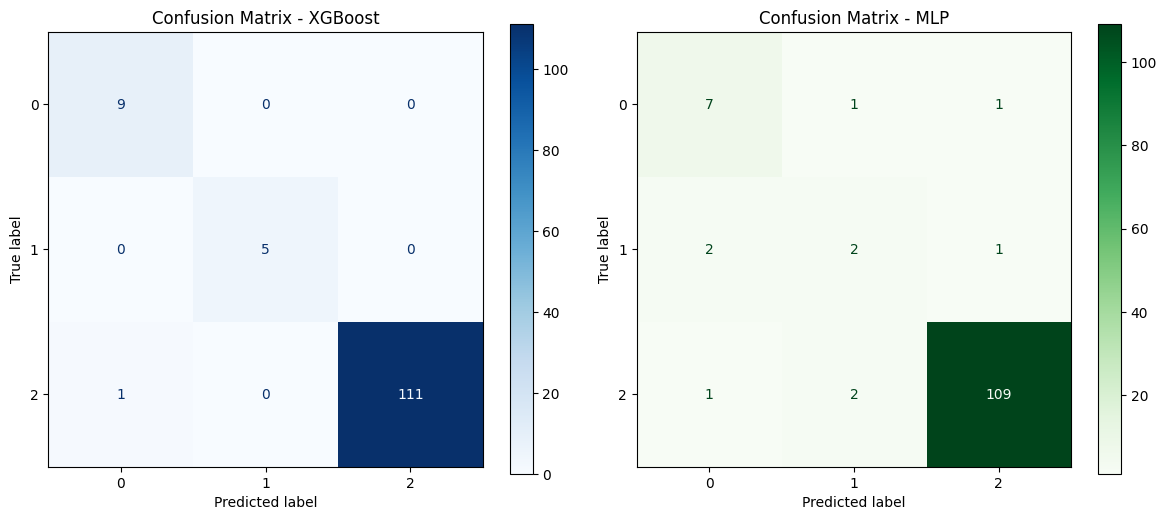

In [59]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay.from_predictions(
    y_test, xgb_preds, ax=axes[0], cmap='Blues')
axes[0].set_title("Confusion Matrix - XGBoost")

ConfusionMatrixDisplay.from_predictions(
    y_test, mlp_preds, ax=axes[1], cmap='Greens')
axes[1].set_title("Confusion Matrix - MLP")

plt.tight_layout()
plt.show()


CM = tabel hasil tebakan vs jawaban aslinya 

Bagian-bagian dalam Confusion Matrix
Tiap kotak menunjukkan:
- Baris = label asli
- Kolom = label tebakan/model

Misalnya:
- Baris 0 Kolom 0: berapa banyak data kelas 0 yang berhasil ditebak sebagai 0 (tebakan benar)
- Baris 1 Kolom 2: berapa banyak data kelas 1 yang salah ditebak sebagai 2


### Perbandingan Akurasi dalam Bar Chart

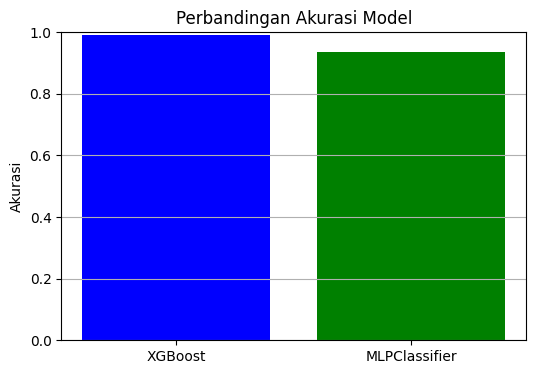

In [60]:
import numpy as np

# Akurasi masing-masing model
acc_xgb = accuracy_score(y_test, xgb_preds)
acc_mlp = accuracy_score(y_test, mlp_preds)

# Visualisasi
plt.figure(figsize=(6, 4))
plt.bar(['XGBoost', 'MLPClassifier'], [acc_xgb, acc_mlp], color=['blue', 'green'])
plt.title('Perbandingan Akurasi Model')
plt.ylabel('Akurasi')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()


# SELESAI

### SET RANDOM SEET KEMBALI

In [61]:
import numpy as np
import random

np.random.seed(42)
random.seed(42)


#### Memastikan Random State konsisten

In [62]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)


### Penyimpanan Model Ke .PKL

In [63]:
import joblib

# Simpan model XGBoost dan MLP
joblib.dump(xgb_model, 'xgb_model.pkl')
joblib.dump(mlp_model, 'mlp_model.pkl')


['mlp_model.pkl']

### TUJUAN PKL 
1. Melatih model butuh waktu dan respurce , jadi stelah dilatih , dismpan saja model nya tujuan agar tidak perlu training ulang 
2. bisa digunakan kapan saja

untuk membuka kembali :

model = joblib.load('xgb_model.pkl')

prediksi = model.predict(data_baru)

### Simpan Evaluasi ke CSV

In [64]:
from sklearn.metrics import accuracy_score

acc_xgb = accuracy_score(y_test, xgb_preds)
acc_mlp = accuracy_score(y_test, mlp_preds)


In [65]:
# Simpan hasil evaluasi ke file CSV
evaluation_df = pd.DataFrame({
    'Model': ['XGBoost', 'MLPClassifier'],
    'Accuracy': [acc_xgb, acc_mlp]
})

evaluation_df.to_csv("model_evaluation.csv", index=False)
print("Hasil evaluasi disimpan ke model_evaluation.csv")


Hasil evaluasi disimpan ke model_evaluation.csv


#### nilai keluaran tanpa disimpan

In [66]:
# Save models
joblib.dump(xgb_model, 'xgb_model.pkl')
joblib.dump(mlp_model, 'mlp_model.pkl')

# Save evaluation
evaluation_results = pd.DataFrame({
    'Model': ['XGBoost', 'MLPClassifier'],
    'Accuracy': [acc_xgb, acc_mlp]
})
evaluation_results.to_csv('model_evaluation.csv', index=False)
evaluation_results

,Model,Accuracy
0,XGBoost,0.992063
1,MLPClassifier,0.936508
